In [1]:
!pip install blosum
!pip install biopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 2.2 MB/s eta 0:00:00


In [2]:
# initialising necessities

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import blosum as bl
from collections import Counter
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from scipy.stats import rankdata
from xgboost import XGBRegressor
from biopandas.pdb import PandasPdb

blosum_matrix = bl.BLOSUM(62, -10)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amino-acid-information/amino.csv
/kaggle/input/novozymes-enzyme-stability-prediction/sample_submission.csv
/kaggle/input/novozymes-enzyme-stability-prediction/wildtype_structure_prediction_af2.pdb
/kaggle/input/novozymes-enzyme-stability-prediction/train.csv
/kaggle/input/novozymes-enzyme-stability-prediction/test.csv
/kaggle/input/novozymes-enzyme-stability-prediction/train_updates_20220929.csv


In [3]:
# loading train data
# from https://www.kaggle.com/dschettler8845
def load_fixed_train_df(original_train_file_path="/kaggle/input/novozymes-enzyme-stability-prediction/train.csv",
                        update_file_path="/kaggle/input/novozymes-enzyme-stability-prediction/train_updates_20220929.csv",
                        was_fixed_col=False):
    def _fix_tm_ph(_row, update_map):
        update_vals = update_map.get(_row["seq_id"], None)
        if update_vals is not None:
            _row["tm"] = update_vals["tm"]
            _row["pH"] = update_vals["pH"]
        return _row

    # Load dataframes
    _df = pd.read_csv(original_train_file_path)
    _updates_df = pd.read_csv(update_file_path)

    # Identify which sequence ids need to have the tm and pH values changed and create a dictionary mapping 
    seqid_2_phtm_update_map = _updates_df[~pd.isna(_updates_df["pH"])].groupby("seq_id")[["pH", "tm"]].first().to_dict("index")

    # Identify the sequence ids that will be dropped due to data quality issues
    bad_seqids = _updates_df[pd.isna(_updates_df["pH"])]["seq_id"].to_list()

    # Fix bad sequence ids
    _df = _df[~_df["seq_id"].isin(bad_seqids)].reset_index(drop=True)

    # Fix pH and tm swaparoo
    _df = _df.apply(lambda x: _fix_tm_ph(x, seqid_2_phtm_update_map), axis=1)

    # Add in a bool to track if a row was fixed or not (tm/ph swap will look the same as bad data)
    if was_fixed_col: _df["was_fixed"] = _df["seq_id"].isin(bad_seqids+list(seqid_2_phtm_update_map.keys()))

    return _df

train = load_fixed_train_df()
train.index = train.seq_id
train = train.drop(["seq_id", "data_source"], axis = 1)
print(train.head())
print(train.shape)

                                         protein_sequence   pH    tm
seq_id                                                              
0       AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...  7.0  75.7
1       AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...  7.0  50.5
2       AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...  7.0  40.5
3       AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...  7.0  47.2
4       AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...  7.0  49.5
(28981, 3)


In [4]:
AMINO_ACIDS = ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
WILD_TYPE = "VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK"
pdb_df = PandasPdb().read_pdb("/kaggle/input/novozymes-enzyme-stability-prediction/wildtype_structure_prediction_af2.pdb")
atom_df = pdb_df.df["ATOM"]
map_number_to_b_factor = atom_df.groupby("residue_number").b_factor.mean()

Number of nan in  protein_sequence :  0
Number of nan in  pH :  286
Number of nan in  tm :  0
Ratio of pH nan  0.009868534557123632
Ratio of pH in of range  pH    0.931541
dtype: float64


,pH,tm,protein_length
count,26997.000000,26997.000000,26997.000000
mean,7.018893,51.239497,467.184576
std,0.161061,12.030520,420.622752
min,6.000000,25.100000,5.000000
25%,7.000000,43.600000,231.000000
50%,7.000000,48.600000,368.000000
75%,7.000000,54.200000,554.000000
max,8.000000,130.000000,8798.000000


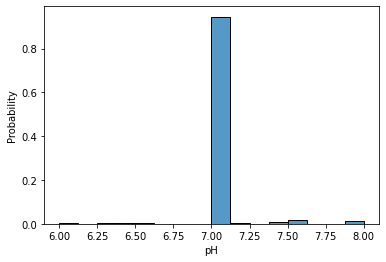

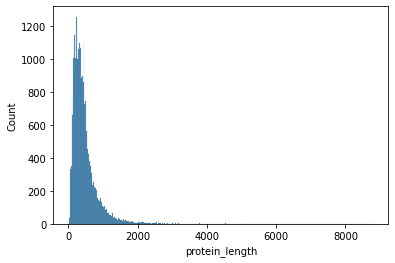

In [5]:
# check training data with visualisation
for col in train.columns:
    print("Number of nan in ", col, ": ", train[col].isnull().sum())

print("Ratio of pH nan ", train["pH"].isnull().sum() / len(train["pH"]))
# pH has 286 nan values -> 0.009868 -> 0.9% of the data
train.dropna()
print("Ratio of pH in of range ", pd.DataFrame({"pH": (train.pH >= 6) & (train.pH <= 8)}).sum() / len(train.pH))
train = train.loc[(train.pH >= 6) & (train.pH <= 8), :]

plt.figure(1)
sns.histplot(data = train, x = "pH", stat = "probability")
# pH data range is from ~2 - 11, but mostly at 7
train["protein_length"] = [len(p) for p in train.protein_sequence]
plt.figure(2)
sns.histplot(data = train, x = "protein_length", stat = "count")

train.describe()

In [6]:
mutation_threshold = 2
deletion_threshold = 1

# helper functions for grouping of proteins
def form_X_groups(data):
    X = data.copy()
    # group protein seqeunces by length
    master = dict()
    for idx in data.index:
        if data.loc[idx, "protein_length"] not in master: master[data.loc[idx, "protein_length"]] = []
        master[data.loc[idx, "protein_length"]].append(idx)
    
    # for each length, further group into similar proteins
    # mutation distance max = 2
    # assume no wild type in train data, means (non wild 1) -mutation-> (wild) -mutation-> (non wild 2)
    
    total_groups = 1
    lengths = sorted(master.keys(), reverse = True)
    X["group"] = [0 for i in range(data.shape[0])]
    master_groupings = dict()
    for length in lengths:
        for i in range(len(master[length])):
            first_protein_idx = master[length][i]
            first_protein = X.loc[first_protein_idx, "protein_sequence"]
            if X.loc[first_protein_idx, "group"] == 0:
                X.loc[first_protein_idx, "group"] = total_groups
                master_groupings[total_groups] = [first_protein_idx]
                total_groups += 1
                
            for j in range(i + 1, len(master[length])):
                second_protein_idx = master[length][j]
                second_protein = X.loc[second_protein_idx, "protein_sequence"]
                if X.loc[second_protein_idx, "group"] == X.loc[first_protein_idx, "group"]: continue
                if compareProteinsSameLength(first_protein, second_protein):
                    if X.loc[second_protein_idx, "group"] != 0:
                        changeProteinGroup(X, master_groupings, X.loc[first_protein_idx, "group"], X.loc[second_protein_idx, "group"])
                    else:
                        X.loc[second_protein_idx, "group"] = X.loc[first_protein_idx, "group"]
                        master_groupings[X.loc[first_protein_idx, "group"]].append(second_protein_idx)
                
            for new_length in range(length - deletion_threshold, length):
                if new_length not in master: continue
                for third_protein_idx in master[new_length]:
                    third_protein = X.loc[third_protein_idx, "protein_sequence"]
                    if X.loc[third_protein_idx, "group"] == X.loc[first_protein_idx, "group"]: continue
                    if compareProteinsDiffLength(first_protein, third_protein, 0):
                        if X.loc[third_protein_idx, "group"] != 0:
                            changeProteinGroup(X, master_groupings, X.loc[first_protein_idx, "group"], X.loc[third_protein_idx, "group"])
                        else:
                            X.loc[third_protein_idx, "group"] = X.loc[first_protein_idx, "group"]
                            master_groupings[X.loc[first_protein_idx, "group"]].append(third_protein_idx)
    return X


def compareProteinsSameLength(protein_1, protein_2):
    mutations = 0
    for i in range(len(protein_1)):
        if protein_1[i] != protein_2[i]:
            mutations += 1
            if mutations > mutation_threshold: return False
    return True

def compareProteinsDiffLength(protein_1, protein_2, deletions):
    if deletions == deletion_threshold: return False
    mutations = 0
    for i in range(len(protein_2)):
        if protein_1[i] != protein_2[i]:
            if protein_1[i + 1:] == protein_2[i:]: return True
            if len(protein_1[i + 1:]) == len(protein_2[i:]):
                return compareProteinsSameLength(protein_1[i + 1:], protein_2[i:])
            else:
                if compareProteinsDiffLength(protein_1[i + 1:], protein_2[i:], deletions + 1): return True
                mutations += 1
                if mutations > mutation_threshold - deletions - deletion_threshold: return False
    return True

def changeProteinGroup(X, master_groupings, first_protein_group, second_protein_group):
    similar_proteins = master_groupings[second_protein_group]
    del master_groupings[second_protein_group]
    for sp in similar_proteins:
        X.loc[sp, "group"] = first_protein_group
    master_groupings[first_protein_group].extend(similar_proteins)
    return X, master_groupings

In [7]:
X_groups = form_X_groups(train)
print(X_groups.head())
print(X_groups.shape)
print(X_groups.describe())

                                         protein_sequence   pH    tm  \
seq_id                                                                 
0       AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...  7.0  75.7   
1       AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...  7.0  50.5   
2       AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...  7.0  40.5   
3       AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...  7.0  47.2   
4       AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...  7.0  49.5   

        protein_length  group  
seq_id                         
0                  341  13892  
1                  286  16594  
2                  497   8056  
3                  265  17489  
4                 1451    734  
(26997, 5)
                 pH            tm  protein_length         group
count  26997.000000  26997.000000    26997.000000  26997.000000
mean       7.018893     51.239497      467.184576  12762.233322
std        0.161061     12.030520      420.622752   7189.291868
min 

In [8]:
# since we are interested in mutations, identify groups that have <5 proteins in them (need some proteins to guess wildtype)
grouping_index = X_groups.group.value_counts().gt(4).index
boolean_array = X_groups.group.value_counts().gt(4)
groups_sig = set(grouping_index[boolean_array])
print(len(groups_sig))
print(X_groups.group.value_counts().lt(2).sum())

74
24287


(2374, 5)
                pH           tm  protein_length         group
count  2374.000000  2374.000000     2374.000000   2374.000000
mean      7.205333    54.595451      251.122157  18068.885004
std       0.498476    12.817836      164.224298   6087.228041
min       6.000000    25.100000       53.000000   1299.000000
25%       7.000000    45.800000      142.000000  10909.000000
50%       7.000000    54.500000      170.000000  21646.000000
75%       7.500000    62.000000      415.000000  22666.000000
max       8.000000   103.000000     1159.000000  24449.000000


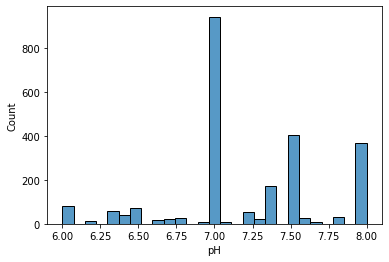

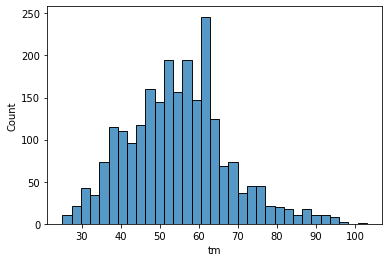

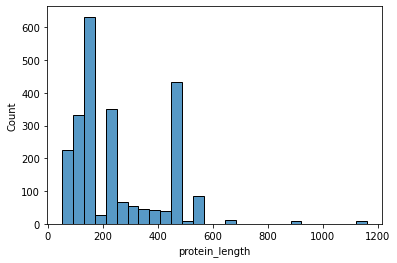

In [9]:
# significant groups are groups with >=5 mutations strings
# note: potential that a wild type is among hte 5 strings, but we will just assume that it is a low chance
X_sig_groups = X_groups.loc[[grp in groups_sig for grp in X_groups.group]]
print(X_sig_groups.shape)
print(X_sig_groups.describe())
for i, col in enumerate(["pH", "tm", "protein_length"]):
    plt.figure(i)
    sns.histplot(data = X_sig_groups, x = col)

In [10]:
# for each group, we count the frequency of each amino acid at each position for proteins of the longest length
# the amino acid with the highest frequency at each position will form our wild type
# from the wild type, we can identify the mutation position of the protein sequence

# for change in tm, we take the sigmoid(tm - min_tm) (negative as change in tm is negatively correlated with change in gibbs energy)

def form_X_difference(data):
    X_diff = data.copy()
    X_diff["diff_position"]= [0 for i in range(data.shape[0])]
    X_diff["dtm"] = [0 for i in range(data.shape[0])]
    X_diff["WT_AA"] = ["-" for i in range(data.shape[0])]
    X_diff["MUT_AA"] = ["-" for i in range(data.shape[0])]
        
    for grp in list(groups_sig):
        data_curr = data.loc[[g == grp for g in data.group]]
        data_curr_no_deletion = data_curr.loc[[pl == data_curr.protein_length.max() for pl in data_curr.protein_length]]
        
        # form wild type sequence
        wild = ""
        for i in range(int(max(data_curr.protein_length))):
            c = Counter()
            for ps in data_curr_no_deletion.protein_sequence:
                c[ps[i]] += 1
            wild += c.most_common(1)[0][0]
        
        # obtain position of mutation or deletion
        # obtain change in tm (dtm)
        max_tm, min_tm = X_diff.tm.max(), X_diff.tm.min()
        for idx in data_curr.index:
            X_diff.loc[idx, "diff_position"], X_diff.loc[idx, "WT_AA"], X_diff.loc[idx, "MUT_AA"] = find_position_difference(wild, data_curr.loc[idx, "protein_sequence"])
            X_diff.loc[idx, "dtm"] = 0 if max_tm == min_tm else - (X_diff.loc[idx, "tm"] - min_tm) / (max_tm - min_tm)
            
    return X_diff

def find_position_difference(wild, ps):
    for i in range(len(ps)):
        if wild[i] != ps[i]:
            if len(wild) == len(ps):
                return i + 1, wild[i], ps[i]
            else:
                return i + 1, wild[i], "-"
    return 0, "-", "-"

In [11]:
X_diff = form_X_difference(X_sig_groups)
X_diff.head()

,protein_sequence,pH,tm,protein_length,group,diff_position,dtm,WT_AA,MUT_AA
seq_id,,,,,,,,,
266,AKGMSKMPQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...,7.5,58.0,53,24449,1,-0.422336,M,A
972,DTSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,7.0,45.2,96,23889,2,-0.258023,V,T
973,DTSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,7.0,48.4,96,23889,2,-0.299101,V,T
974,DTSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,7.0,48.0,96,23889,2,-0.293967,V,T
982,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQAGVVFQNRESVLPT...,7.0,31.8,96,23889,33,-0.086008,D,A


In [12]:
print(X_diff.shape)
print(X_diff.describe())
X_diff.corr('spearman').style.background_gradient(axis=None, cmap="YlGnBu").format('{:.2f}')

(2374, 9)
                pH           tm  protein_length         group  diff_position  \
count  2374.000000  2374.000000     2374.000000   2374.000000    2374.000000   
mean      7.205333    54.595451      251.122157  18068.885004     118.205139   
std       0.498476    12.817836      164.224298   6087.228041      97.377472   
min       6.000000    25.100000       53.000000   1299.000000       0.000000   
25%       7.000000    45.800000      142.000000  10909.000000      45.000000   
50%       7.000000    54.500000      170.000000  21646.000000      95.000000   
75%       7.500000    62.000000      415.000000  22666.000000     157.000000   
max       8.000000   103.000000     1159.000000  24449.000000     463.000000   

               dtm  
count  2374.000000  
mean     -0.378632  
std       0.164542  
min      -1.000000  
25%      -0.473684  
50%      -0.377407  
75%      -0.265725  
max      -0.000000  


,pH,tm,protein_length,group,diff_position,dtm
pH,1.00,0.16,0.46,-0.46,0.23,-0.16
tm,0.16,1.00,0.08,-0.08,-0.03,-1.00
protein_length,0.46,0.08,1.00,-1.00,0.61,-0.08
group,-0.46,-0.08,-1.00,1.00,-0.61,0.08
diff_position,0.23,-0.03,0.61,-0.61,1.00,0.03
dtm,-0.16,-1.00,-0.08,0.08,0.03,1.00


In [13]:
# remove unwanted columns
print(X_diff.columns)
unwanted_cols = ['protein_sequence', 'tm', 'protein_length', 'group', 'pH']
X_diff.dropna(inplace = True)
X_train = X_diff.drop(unwanted_cols, axis = 1)
y_train = X_train.pop("dtm")
X_train = X_train.astype({"WT_AA": "category", "MUT_AA": "category"})
print(X_train.head())
print(y_train.head())

Index(['protein_sequence', 'pH', 'tm', 'protein_length', 'group',
       'diff_position', 'dtm', 'WT_AA', 'MUT_AA'],
      dtype='object')
        diff_position WT_AA MUT_AA
seq_id                            
266                 1     M      A
972                 2     V      T
973                 2     V      T
974                 2     V      T
982                33     D      A
seq_id
266   -0.422336
972   -0.258023
973   -0.299101
974   -0.293967
982   -0.086008
Name: dtm, dtype: float64


In [14]:
WT_AA_copy, MUT_AA_copy = X_train.WT_AA.copy(), X_train.MUT_AA.copy()
WT_AA_dummy = pd.get_dummies(WT_AA_copy, prefix = "WT_AA")
MUT_AA_dummy = pd.get_dummies(MUT_AA_copy, prefix = "MUT_AA")
X_train_dummy = pd.concat([X_train, WT_AA_dummy, MUT_AA_dummy], axis = 1)
X_train_dummy = X_train_dummy.drop(["WT_AA", "MUT_AA"], axis = 1)
print(X_train_dummy.head())
print(X_train_dummy.describe())

        diff_position  WT_AA_-  WT_AA_A  WT_AA_C  WT_AA_D  WT_AA_E  WT_AA_F  \
seq_id                                                                        
266                 1        0        0        0        0        0        0   
972                 2        0        0        0        0        0        0   
973                 2        0        0        0        0        0        0   
974                 2        0        0        0        0        0        0   
982                33        0        0        0        1        0        0   

        WT_AA_G  WT_AA_H  WT_AA_I  ...  MUT_AA_M  MUT_AA_N  MUT_AA_P  \
seq_id                             ...                                 
266           0        0        0  ...         0         0         0   
972           0        0        0  ...         0         0         0   
973           0        0        0  ...         0         0         0   
974           0        0        0  ...         0         0         0   
982           

In [15]:
def form_X_test(data):
    X_test = data.copy()
    X_test["diff_position"] = [0 for i in range(data.shape[0])]
    X_test["WT_AA"] = ["-" for i in range(data.shape[0])]
    X_test["MUT_AA"] = ["-" for i in range(data.shape[0])]
    # obtain position of mutation or deletion
    for idx in data.index:
        X_test.loc[idx, "diff_position"], X_test.loc[idx, "WT_AA"], X_test.loc[idx, "MUT_AA"] = find_position_difference(WILD_TYPE, data.loc[idx, "protein_sequence"])
    return X_test

In [16]:
# load test data and get difference between test data and wild type
# prediction is the change in tm from test sequence and wild type
test = pd.read_csv("/kaggle/input/novozymes-enzyme-stability-prediction/test.csv", index_col = "seq_id")
X_test = form_X_test(test)
X_test.head()

,protein_sequence,pH,data_source,diff_position,WT_AA,MUT_AA
seq_id,,,,,,
31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,17,L,E
31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,17,L,K
31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,17,L,-
31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,18,K,C
31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,18,K,F


In [17]:
WT_AA_test_copy, MUT_AA_test_copy = X_test.WT_AA.copy(), X_test.MUT_AA.copy()
WT_AA_test_dummy = pd.get_dummies(WT_AA_test_copy, prefix = "WT_AA")
MUT_AA_test_dummy = pd.get_dummies(MUT_AA_test_copy, prefix = "MUT_AA")
X_test_dummy = pd.concat([X_test, WT_AA_test_dummy, MUT_AA_test_dummy], axis = 1)
X_test_dummy = X_test_dummy.drop(["WT_AA", "MUT_AA"], axis = 1)
X_test_dummy.head()

,protein_sequence,pH,data_source,diff_position,WT_AA_-,WT_AA_A,WT_AA_D,WT_AA_E,WT_AA_F,WT_AA_G,...,MUT_AA_M,MUT_AA_N,MUT_AA_P,MUT_AA_Q,MUT_AA_R,MUT_AA_S,MUT_AA_T,MUT_AA_V,MUT_AA_W,MUT_AA_Y
seq_id,,,,,,,,,,,,,,,,,,,,,
31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,17,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,17,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,17,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,18,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,18,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
X_test_final = X_test_dummy.drop(["protein_sequence", "data_source", 'pH'], axis = 1)
X_test_final.head()

,diff_position,WT_AA_-,WT_AA_A,WT_AA_D,WT_AA_E,WT_AA_F,WT_AA_G,WT_AA_I,WT_AA_K,WT_AA_L,...,MUT_AA_M,MUT_AA_N,MUT_AA_P,MUT_AA_Q,MUT_AA_R,MUT_AA_S,MUT_AA_T,MUT_AA_V,MUT_AA_W,MUT_AA_Y
seq_id,,,,,,,,,,,,,,,,,,,,,
31390,17,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
31391,17,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
31392,17,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
31393,18,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
31394,18,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
X_test_cols = set(X_test_final.columns)
unwanted_train_cols = []
for col in X_train_dummy.columns:
    if col not in X_test_cols: unwanted_train_cols.append(col)
print(unwanted_train_cols)
X_train_dummy = X_train_dummy.drop(unwanted_train_cols, axis = 1)
print(X_train_dummy.describe())

['WT_AA_C', 'WT_AA_H', 'WT_AA_M']
       diff_position      WT_AA_-      WT_AA_A      WT_AA_D      WT_AA_E  \
count    2374.000000  2374.000000  2374.000000  2374.000000  2374.000000   
mean      118.205139     0.013058     0.061078     0.081297     0.085088   
std        97.377472     0.113548     0.239524     0.273349     0.279072   
min         0.000000     0.000000     0.000000     0.000000     0.000000   
25%        45.000000     0.000000     0.000000     0.000000     0.000000   
50%        95.000000     0.000000     0.000000     0.000000     0.000000   
75%       157.000000     0.000000     0.000000     0.000000     0.000000   
max       463.000000     1.000000     1.000000     1.000000     1.000000   

           WT_AA_F      WT_AA_G      WT_AA_I      WT_AA_K      WT_AA_L  ...  \
count  2374.000000  2374.000000  2374.000000  2374.000000  2374.000000  ...   
mean      0.033277     0.060236     0.045914     0.049284     0.049705  ...   
std       0.179397     0.237973     0.209343

In [20]:
# find best parameters for change in tm
"""
potential_n_estimators = [2000, 2500, 3000, 4000]
potential_learning_rates = [0.008, 0.006, 0.004, 0.002]
kf = KFold(n_splits = 3, shuffle = True, random_state = 27)
X_train_kfold, y_train_kfold = X_train_dummy.copy(), y_train.copy()
X_train_kfold, y_train_kfold = X_train_dummy.reset_index(), y_train.reset_index()
X_train_kfold, y_train_kfold = X_train_kfold.drop("seq_id", axis = 1), y_train_kfold.drop("seq_id", axis = 1)
for pne in potential_n_estimators:
    cycle = []
    for plr in potential_learning_rates:
        model = XGBRegressor(n_estimators = pne, learning_rate = plr)
        val_results_spearmanr = []
        for train_index, val_index in kf.split(X_train_kfold, y_train_kfold):
            X_train_fold, y_train_fold = X_train_kfold.loc[train_index, :], y_train_kfold.loc[train_index, :]
            X_val_fold, y_val_fold = X_train_kfold.loc[val_index, :], y_train_kfold.loc[val_index, :]
            model.fit(X_train_fold, y_train_fold)
            val_fold_predictions = model.predict(X_val_fold)
            r, p_val = spearmanr(val_fold_predictions, y_val_fold)
            val_results_spearmanr.append(r)
        cycle.append(round(np.mean(val_results_spearmanr), 5))
    print(pne, cycle)

CV results
potential_n_estimators = [100, 500, 1000, 2000]
potential_learning_rates = [0.1, 0.05, 0.01, 0.005]
100 [0.33392, 0.32685, 0.26966, 0.24979]
500 [0.32512, 0.33414, 0.33347, 0.31588]
1000 [0.31801, 0.3268, 0.33662, 0.33412]
2000 [0.31431, 0.31837, 0.33176, 0.33831]

potential_n_estimators = [2000, 2500, 3000, 4000]
potential_learning_rates = [0.008, 0.006, 0.004, 0.002]
2000 [0.33631, 0.33825, 0.33528, 0.32854]
2500 [0.33325, 0.33837, 0.33464, 0.33453]
3000 [0.33315, 0.33642, 0.33676, 0.33608]
4000 [0.33292, 0.33516, 0.33458, 0.33439]
"""

'\npotential_n_estimators = [2000, 2500, 3000, 4000]\npotential_learning_rates = [0.008, 0.006, 0.004, 0.002]\nkf = KFold(n_splits = 3, shuffle = True, random_state = 27)\nX_train_kfold, y_train_kfold = X_train_dummy.copy(), y_train.copy()\nX_train_kfold, y_train_kfold = X_train_dummy.reset_index(), y_train.reset_index()\nX_train_kfold, y_train_kfold = X_train_kfold.drop("seq_id", axis = 1), y_train_kfold.drop("seq_id", axis = 1)\nfor pne in potential_n_estimators:\n    cycle = []\n    for plr in potential_learning_rates:\n        model = XGBRegressor(n_estimators = pne, learning_rate = plr)\n        val_results_spearmanr = []\n        for train_index, val_index in kf.split(X_train_kfold, y_train_kfold):\n            X_train_fold, y_train_fold = X_train_kfold.loc[train_index, :], y_train_kfold.loc[train_index, :]\n            X_val_fold, y_val_fold = X_train_kfold.loc[val_index, :], y_train_kfold.loc[val_index, :]\n            model.fit(X_train_fold, y_train_fold)\n            val_fold

In [21]:
# form model to predict change in tm
delta_tm_model = XGBRegressor(n_estimators = 2500, learning_rate = 0.006)
delta_tm_model.fit(X_train_dummy, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.006, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=2500,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [22]:
# make predictions on delta tm
predictions = pd.DataFrame({"prediction": delta_tm_model.predict(X_test_final)}, index = test.index)
print(predictions.head(10))

        prediction
seq_id            
31390    -0.310490
31391    -0.330085
31392    -0.327204
31393    -0.404758
31394    -0.429128
31395    -0.406131
31396    -0.371825
31397    -0.315101
31398    -0.225462
31399    -0.284215


In [23]:
rank_df = pd.concat([X_test, predictions], axis = 1)
rank_df["blosum_score"] = [-10 for i in range(rank_df.shape[0])]
for idx in rank_df.index:
    if rank_df.loc[idx, "diff_position"] == 0:
        rank_df.loc[idx, "blosum_score"] = 0
    elif rank_df.loc[idx, "MUT_AA"] == "-":
        rank_df.loc[idx, "blosum_score"] = -10
    else:
        rank_df.loc[idx, "blosum_score"] = min(0, blosum_matrix[X_test.loc[idx, "WT_AA"] + X_test.loc[idx, "MUT_AA"]])
rank_df["b_factor"] = X_test.diff_position.map(map_number_to_b_factor).fillna(0)
rank_df.head()

,protein_sequence,pH,data_source,diff_position,WT_AA,MUT_AA,prediction,blosum_score,b_factor
seq_id,,,,,,,,,
31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,17,L,E,-0.310490,-3,55.23
31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,17,L,K,-0.330085,-2,55.23
31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,17,L,-,-0.327204,-10,55.23
31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,18,K,C,-0.404758,-3,69.25
31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,18,K,F,-0.429128,-3,69.25


In [24]:
rank_df["prediction_rank"] = rankdata(rank_df.prediction)
rank_df["b_factor_rank"] = rankdata(-rank_df.b_factor)
rank_df["blosum_score_rank"] = rankdata(rank_df.blosum_score)
rank_df["final"] = rank_df.apply(lambda x: np.power(x.prediction_rank * x.b_factor_rank * x.blosum_score_rank, 1/3), axis = 1)
rank_df.head()

,protein_sequence,pH,data_source,diff_position,WT_AA,MUT_AA,prediction,blosum_score,b_factor,prediction_rank,b_factor_rank,blosum_score_rank,final
seq_id,,,,,,,,,,,,,
31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,17,L,E,-0.310490,-3,55.23,2096.0,2408.0,396.0,1259.643497
31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,17,L,K,-0.330085,-2,55.23,1900.0,2408.0,924.5,1617.232026
31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,17,L,-,-0.327204,-10,55.23,1922.0,2408.0,39.0,565.142746
31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,18,K,C,-0.404758,-3,69.25,902.0,2386.5,396.0,948.173298
31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,18,K,F,-0.429128,-3,69.25,593.0,2386.5,396.0,824.461612


In [25]:
output = pd.DataFrame({"seq_id": rank_df.index, 'tm': rank_df.final})
output.to_csv('submission.csv', index = False)

Learning Points

Statistics:
Spearman's Correlation
- measures the strength of association between two ranked variables
- data ideally monotonic
- to manually do it, consider two sets of data
1. rank the data in descending order (i.e. 1 is for the largest observation)
2. if there are data that share the same value, take the average of the ranks if they were not ordered
    e.g. if there are two values of 60, and they should fill the 6th and 7th place, then their ranks would be (6 + 7) / 2 = 6.5
3. formula for spearman's r:
    a. if there are no tied observations:
        rho = 1 - (6 * sum((d_i)^2) / (n * (n^2 - 1))
            d_i: difference in ranks of observation i
            n: number of observations
    b. if there are tied observations:
        rho = sum((x_i - x_bar) * (y_i - y_bar)) / sqrt(sum((x_i - x_bar)^2 * (y_i - y_bar)^2))
- value of spearman's r lies between -1 and 1 (inclusive)
- closer to 0 means lower the association, 1 means perfect positive association, -1 means perfect negative association
- can run hypothesis tests on spearman's r (scipy spearmanr function provides both rho and p-value)
    - H_0: there is no monotonic association between the two variables
    - H_1: there is a monotonic association between the two variables

Rank Data

Biometrics
Blosum Substitution Score
B_factor